This is an experimental (stub...) Schema.org dashboard using Jupyter/iPython

In [1]:
# Import libraries

import unittest
import os
import pprint
from os import path, getenv
from os.path import expanduser
import logging # https://docs.python.org/2/library/logging.html#logging-levels
import glob
import argparse
import StringIO
import sys

# 3rd party, see e.g. http://pbpython.com/simple-graphing-pandas.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.__version__
%matplotlib inline

# Locally,

print os.getcwd()
if os.getcwd().endswith('schemaorg'):
    print "Working from: ", os.getcwd()
else:
    #print "cd .."
    os.chdir("..")

# We'll need our lib/ dir, plus AppEngine's files:
sys.path.append( os.getcwd() ) 
sdk_path = getenv('APP_ENGINE',  expanduser("~") + '/google-cloud-sdk/platform/google_appengine/')
sys.path.insert(0, sdk_path) 
print "GAE: ", sdk_path

# previous useful:
import dev_appserver
dev_appserver.fix_sys_path()
# pprint.pprint(os.environ.copy())

/Users/danbri/sdo/official/schemaorg/scripts
GAE:  /Users/danbri/google-cloud-sdk/platform/google_appengine/


In [2]:
import rdflib
from rdflib import Graph
from rdflib import RDF, RDFS
from rdflib.term import URIRef, Literal
from rdflib.parser import Parser
from rdflib.serializer import Serializer
from rdflib.plugins.sparql import prepareQuery
from rdflib.compare import graph_diff
import threading
from api import inLayer,read_file, full_path, read_schemas, read_extensions, read_examples, namespaces, DataCache, getMasterStore
from api import  setInTestHarness, GetAllTypes, Unit, GetImmediateSubtypes # old API
from apirdflib import getNss



In [3]:
# Setup
setInTestHarness(True)
import sdoapp

rdflib.plugin.register("json-ld", Serializer, "rdflib_jsonld.serializer", "JsonLDSerializer")

store = getMasterStore()
read_schemas(loadExtensions=True)
read_extensions(sdoapp.ENABLED_EXTENSIONS)
graphs = list(store.graphs())

In [4]:
# Utilities

def findGraph(guri):
    myg = ""
    for g in graphs:
      #print g.identifier
      if str(g.identifier) == guri:
          myg = g
          # print "Found graph %s for graph URI %s" % (g, guri)
    # print myg
    if myg == "":
        print "Didn't find graph %s." % guri
        return None
    else:
        return myg

# Convert SPARQL results to Pandas DataFrame:
from pandas import DataFrame

def sparql2df(a):
    c = []
    for b in a.bindings:
        rowvals=[]
        for k in a.vars:
            rowvals.append(b[k])
        c.append(rowvals)

    df = DataFrame(c)
    df.columns = [str(v) for v in a.vars]
    return df

# Overview

We have two APIs, the original pseudo-RDF unit/node structure, plus also now RDFLib. 
It is better to use the latter as it gives access to SPARQL, parsers/serializers etc.

In [5]:
sdocore = findGraph("http://schema.org/")
bibex = findGraph("http://bib.schema.org/")
auto = findGraph("http://auto.schema.org/")


In [7]:
# Test OLD API (skip this, unless debugging; slow on first run.)

pprint.pprint( "Found %s types." % len( GetAllTypes() ) )
for t in ["Article", "CreativeWork", "Product", "MedicalEntity", "Event"]: 
    someType = Unit.GetUnit(t)
    p_subtypes = GetImmediateSubtypes(someType)
    pprint.pprint( "Direct subtypes of %s: %s" % ( someType.id, ', '.join([str(x.id) for x in p_subtypes]) ) )
 

'Found 583 types.'
u'Direct subtypes of Article: NewsArticle, Report, ScholarlyArticle, SocialMediaPosting, TechArticle'
u'Direct subtypes of CreativeWork: Article, Blog, Book, Clip, Code, Comment, Conversation, CreativeWorkSeason, CreativeWorkSeries, DataCatalog, Dataset, DigitalDocument, Episode, Game, Map, MediaObject, Message, Movie, MusicComposition, MusicPlaylist, MusicRecording, Painting, Photograph, PublicationIssue, PublicationVolume, Question, Recipe, Review, Sculpture, Season, Series, SoftwareApplication, SoftwareSourceCode, TVSeason, TVSeries, VisualArtwork, WebPage, WebPageElement, WebSite'
u'Direct subtypes of Product: IndividualProduct, ProductModel, SomeProducts, Vehicle'
u'Direct subtypes of MedicalEntity: '
u'Direct subtypes of Event: BusinessEvent, ChildrensEvent, ComedyEvent, DanceEvent, DeliveryEvent, EducationEvent, ExhibitionEvent, Festival, FoodEvent, LiteraryEvent, MusicEvent, PublicationEvent, SaleEvent, ScreeningEvent, SocialEvent, SportsEvent, TheaterEvent, 

In [8]:
renamed =  sdocore.query("select ?x ?y where { ?x <http://schema.org/supersededBy> ?y }")

for (old, new) in renamed:
    print "older: %s -> newer: %s" % (old, new)

older: http://schema.org/course -> newer: http://schema.org/exerciseCourse
older: http://schema.org/assembly -> newer: http://schema.org/executableLibraryName
older: http://schema.org/datasetTimeInterval -> newer: http://schema.org/temporalCoverage
older: http://schema.org/requirements -> newer: http://schema.org/softwareRequirements
older: http://schema.org/serviceAudience -> newer: http://schema.org/audience
older: http://schema.org/map -> newer: http://schema.org/hasMap
older: http://schema.org/founders -> newer: http://schema.org/founder
older: http://schema.org/option -> newer: http://schema.org/actionOption
older: http://schema.org/merchant -> newer: http://schema.org/seller
older: http://schema.org/isBasedOnUrl -> newer: http://schema.org/isBasedOn
older: http://schema.org/tracks -> newer: http://schema.org/track
older: http://schema.org/albums -> newer: http://schema.org/album
older: http://schema.org/branchOf -> newer: http://schema.org/parentOrganization
older: http://schema.

In [9]:
a = bibex.query("select ?x ?p ?y where { ?x ?p ?y } LIMIT 3")
sparql2df(a)

,x,p,y
0,http://schema.org/publishedBy,http://schema.org/isPartOf,http://bib.schema.org
1,http://schema.org/variantCover,http://schema.org/category,Comics
2,http://schema.org/abridged,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...


In [10]:
sparql2df( sdocore.query("select ?item ?type where { ?item a ?type }") )

,item,type
0,http://schema.org/LoanOrCredit,http://www.w3.org/2000/01/rdf-schema#Class
1,http://schema.org/VenueMap,http://schema.org/MapCategoryType
2,http://schema.org/CheckAction,http://www.w3.org/2000/01/rdf-schema#Class
3,http://schema.org/TrainStation,http://www.w3.org/2000/01/rdf-schema#Class
4,http://schema.org/RsvpResponseNo,http://schema.org/RsvpResponseType
5,http://schema.org/DanceGroup,http://www.w3.org/2000/01/rdf-schema#Class
6,http://schema.org/position,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...
7,http://schema.org/Store,http://www.w3.org/2000/01/rdf-schema#Class
8,http://schema.org/MedicalOrganization,http://www.w3.org/2000/01/rdf-schema#Class
9,http://schema.org/coverageStartTime,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...


In [11]:
s="""SELECT ?child (count(?grandchild) as ?nGrandchildren) where {
  ?child rdfs:subClassOf schema:Thing .
  OPTIONAL { ?grandchild rdfs:subClassOf ?child }
}
GROUP BY ?child order by desc(count(?grandchild))"""
ets = sparql2df(  sdocore.query(s) )
# Count subtypes

                            child  nGrandchildren
0  http://schema.org/CreativeWork              39
1    http://schema.org/Intangible              36
2         http://schema.org/Event              19
3        http://schema.org/Action              14
4  http://schema.org/Organization               9
5         http://schema.org/Place               8
6       http://schema.org/Product               4
7        http://schema.org/Person               1


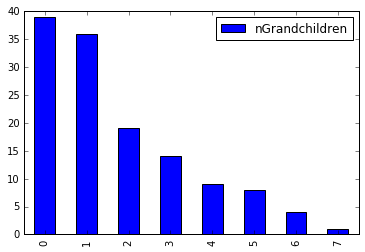

In [12]:
ets = ets.apply(lambda x: pd.to_numeric(x, errors='ignore'))
print ets
ets.plot(kind='bar')

# ets['nGrandchildren']

In [13]:
ets

,child,nGrandchildren
0,http://schema.org/CreativeWork,39
1,http://schema.org/Intangible,36
2,http://schema.org/Event,19
3,http://schema.org/Action,14
4,http://schema.org/Organization,9
5,http://schema.org/Place,8
6,http://schema.org/Product,4
7,http://schema.org/Person,1


In [14]:
sparql2df( sdocore.query("select ?x where { ?x rdfs:subClassOf <http://schema.org/Event> } LIMIT 30 ") )


,x
0,http://schema.org/SportsEvent
1,http://schema.org/DeliveryEvent
2,http://schema.org/ExhibitionEvent
3,http://schema.org/EducationEvent
4,http://schema.org/DanceEvent
5,http://schema.org/VisualArtsEvent
6,http://schema.org/ScreeningEvent
7,http://schema.org/ComedyEvent
8,http://schema.org/UserInteraction
9,http://schema.org/TheaterEvent


In [15]:
sdocore

<Graph identifier=http://schema.org/ (<class 'rdflib.graph.Graph'>)>

In [16]:
s = "select ?x where { ?x rdfs:subClassOf <http://schema.org/CreativeWork> } LIMIT 60 "
a = sdocore.query(s)
sparql2df( a )

,x
0,http://schema.org/Review
1,http://schema.org/Message
2,http://schema.org/MusicRecording
3,http://schema.org/PublicationIssue
4,http://schema.org/MusicPlaylist
5,http://schema.org/Season
6,http://schema.org/Question
7,http://schema.org/VisualArtwork
8,http://schema.org/CreativeWorkSeries
9,http://schema.org/Map


In [17]:
# Unit Tests
# Seems we could run them here, https://amodernstory.com/2015/06/28/running-unittests-in-the-ipython-notebook/
# unittest.TextTestRunner().run(suite)